## Data import and preprocessing

#### Setup

In [ ]:
# Change width of Jupyter notebook
from IPython.core.display import display, HTML
from pyspark.sql import SparkSession
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml.clustering import *
from pyspark.ml.evaluation import *
from pyspark.ml.regression import *
from pyspark.ml import Pipeline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
spark = (SparkSession.builder \
    .master('local') \
    .appName('nycHousing') \
    .config('spark.executor.memory', '28g') \
    .config('spark.driver.memory','4g')\
    .config("spark.cores.max", "6") \
    .getOrCreate())
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', 'true')  # enable PyArrow

#### Merging Complaints and Problems files

In [ ]:
# read complaints
cp_df=spark.read.csv("0_Complaint_Problems_May2021.csv",inferSchema=True, header=True)

# housing maintenance 
hmcc_df=spark.read.csv("1_Housing_Maintenance_Code_Complaints_May2021.csv",inferSchema=True, header=True)
hmcc_df = hmcc_df.drop("status", "statusdate", "statusid")

# merge cp_df and hmcc_df together on ComplaintID column
merged_df = cp_df.join(hmcc_df, on=["ComplaintID"])

# population data - read in population data by zipcode for NY
population = spark.read.csv("2_NY_State_Population_by_Zip.csv",inferSchema=True, header=True)
population = population.withColumnRenamed("Zip Code","Zip")

# merge housing data with zipcode-level population data
# https://luminousmen.com/post/introduction-to-pyspark-join-types 
merged_df = merged_df.join(population, on='Zip', how='inner')

# income data - read in income data by zipcode for NY
income = spark.read.csv("3_NY_State_Income_by_Zip.csv",inferSchema=True, header=True)

# rename "Zip Code" to "Zip" to maintain consistency across datasets
# https://sparkbyexamples.com/pyspark/pyspark-rename-dataframe-column/
income = income.withColumnRenamed("Zip Code","Zip")

# merge and rename
# https://sparkbyexamples.com/pyspark/pyspark-cast-column-type/
# https://sparkbyexamples.com/pyspark/pyspark-rename-dataframe-column/
merged_df = merged_df.withColumn("Zip", merged_df.Zip.cast(StringType()))

# merge with income - merg ehousing/income dataset with income dataset, refer to this new dataset as merged_df
# https://luminousmen.com/post/introduction-to-pyspark-join-types 
merged_df = merged_df.join(income, on='Zip', how='inner')

# UHF codes - consolidate the zipcodes using UHF codes
uhf = spark.read.csv("4_uhfzipcodetable.csv",inferSchema=True, header=True)
uhf = uhf.withColumnRenamed("Zip Code","Zip")
uhf = uhf.drop("Borough")

# join merged_df with uhf codes on Zip
merged_df = merged_df.join(uhf, on='Zip', how='inner')

In [ ]:
merged_df.show(1)

+-----+-----------+---------+----------+---------+------------+----------------+------+---------+---------------+-------------+---------------+-------------+------+-------+--------+------+----------+--------------------+----------+---------+-------+-----------+----------+-----+---+---------+--------------+------------+----------+--------------+--------+----------------------+-------------------------+--------+-----------------+
|  Zip|ComplaintID|ProblemID|UnitTypeID| UnitType|SpaceTypeID |       SpaceType|TypeID|     Type|MajorCategoryID|MajorCategory|MinorCategoryID|MinorCategory|CodeID|   Code|StatusID|Status|StatusDate|   StatusDescription|BuildingID|BoroughID|Borough|HouseNumber|StreetName|Block|Lot|Apartment|CommunityBoard|ReceivedDate|Population|All Households|Families|Families with Children|Families without Children|UHF code|Neighborhood name|
+-----+-----------+---------+----------+---------+------------+----------------+------+---------+---------------+-------------+---------

#### Preprocessing: clean columns

In [ ]:
# rename columns
merged_df = merged_df.withColumnRenamed("All Households","All Households Income")
merged_df = merged_df.withColumnRenamed("Families","Families Income")
merged_df = merged_df.withColumnRenamed("Families with Children","Families with Children Income")
merged_df = merged_df.withColumnRenamed("Families without Children","Families without Children Income")

# fix population to integer
merged_df = merged_df.withColumn('Population', regexp_replace('Population', ',', ''))
merged_df = merged_df.withColumn('Population', merged_df['Population'].cast("integer"))

merged_df.show(1)

+-----+-----------+---------+----------+---------+------------+----------------+------+---------+---------------+-------------+---------------+-------------+------+-------+--------+------+----------+--------------------+----------+---------+-------+-----------+----------+-----+---+---------+--------------+------------+----------+---------------------+---------------+-----------------------------+--------------------------------+--------+-----------------+
|  Zip|ComplaintID|ProblemID|UnitTypeID| UnitType|SpaceTypeID |       SpaceType|TypeID|     Type|MajorCategoryID|MajorCategory|MinorCategoryID|MinorCategory|CodeID|   Code|StatusID|Status|StatusDate|   StatusDescription|BuildingID|BoroughID|Borough|HouseNumber|StreetName|Block|Lot|Apartment|CommunityBoard|ReceivedDate|Population|All Households Income|Families Income|Families with Children Income|Families without Children Income|UHF code|Neighborhood name|
+-----+-----------+---------+----------+---------+------------+----------------+

#### Preprocessing: add close time

In [ ]:
# calc close time: convert dates to datetime format and calculate response variable - closing time
# Reference: https://stackoverflow.com/questions/47701339/subtracting-two-date-columns-in-pyspark-python

# preprocessing: convert dates to datetime format and calculate response variable - closing time
timeDiff = (unix_timestamp('StatusDate', 'MM/dd/yyyy') - unix_timestamp('ReceivedDate', 'MM/dd/yyyy')) / 86400 #seconds per day
timeDiff = timeDiff.cast(IntegerType())

# add closing time (time for complaint to be resolved) to dataframe
merged_df = merged_df.withColumn("closeTime", timeDiff)

merged_df.show(5)
#Reference: https://stackoverflow.com/questions/47701339/subtracting-two-date-columns-in-pyspark-python

+-----+-----------+---------+----------+------------+------------+----------------+------+---------+---------------+-------------+---------------+-------------+------+--------------------+--------+------+----------+--------------------+----------+---------+-------+-----------+----------+-----+---+---------+--------------+------------+----------+---------------------+---------------+-----------------------------+--------------------------------+--------+-----------------+---------+
|  Zip|ComplaintID|ProblemID|UnitTypeID|    UnitType|SpaceTypeID |       SpaceType|TypeID|     Type|MajorCategoryID|MajorCategory|MinorCategoryID|MinorCategory|CodeID|                Code|StatusID|Status|StatusDate|   StatusDescription|BuildingID|BoroughID|Borough|HouseNumber|StreetName|Block|Lot|Apartment|CommunityBoard|ReceivedDate|Population|All Households Income|Families Income|Families with Children Income|Families without Children Income|UHF code|Neighborhood name|closeTime|
+-----+-----------+---------

#### Preprocessing: add received month/year

In [ ]:
yfunc = udf(lambda x: (dt.datetime.strptime(x, '%m/%d/%Y')).year, StringType())
mfunc = udf(lambda x: (dt.datetime.strptime(x, '%m/%d/%Y')).month, StringType())
merged_df = merged_df.withColumn('ReceivedYear', yfunc('ReceivedDate'))
merged_df = merged_df.withColumn('ReceivedMonth', mfunc('ReceivedDate'))
merged_df.show(5)

+-----+-----------+---------+----------+------------+------------+----------------+------+---------+---------------+-------------+---------------+-------------+------+--------------------+--------+------+----------+--------------------+----------+---------+-------+-----------+----------+-----+---+---------+--------------+------------+----------+---------------------+---------------+-----------------------------+--------------------------------+--------+-----------------+---------+------------+-------------+
|  Zip|ComplaintID|ProblemID|UnitTypeID|    UnitType|SpaceTypeID |       SpaceType|TypeID|     Type|MajorCategoryID|MajorCategory|MinorCategoryID|MinorCategory|CodeID|                Code|StatusID|Status|StatusDate|   StatusDescription|BuildingID|BoroughID|Borough|HouseNumber|StreetName|Block|Lot|Apartment|CommunityBoard|ReceivedDate|Population|All Households Income|Families Income|Families with Children Income|Families without Children Income|UHF code|Neighborhood name|closeTime|Re

We see that there are some errant values in our response variable - namely the min response time which is negative. We will have to do some investigative work to see what is causing these errant results, as a problem clearly cannot be addressed *before* the initial complaint is even filed. 

In [ ]:
# Statistical summary of response variable
merged_df.select(["closeTime"]).describe().show()#.toPandas().transpose

+-------+------------------+
|summary|         closeTime|
+-------+------------------+
|  count|           4178084|
|   mean|14.006825856062253|
| stddev|38.125920945513165|
|    min|              -995|
|    max|              6531|
+-------+------------------+



In [ ]:
# now write this to a csv
merged_df.write.csv('5_NYC_Merged_Data_May3.csv',mode='overwrite', header='true')

#### Preprocessing: missing and errant data

Only a few columns have missing data: <br>
- StatusDate_missing <br>
- closeTime_missing <br>
- Families with Children_missing

*Idea #1: *  What this tells us is that we have some income data missing regarding Families with Children. One solution could be taking the average of the "All Households", "Families", and "Families without Children" columns. Alternatively, we could focus just on "All Households" data since complaints do not denote whether or not children live in the building/unit. 

*Idea #2: *  We also have some StatusDate information missing which is resulting in some closeTime data being missing (since closeTime is based on StatusDate. An empty cell for StatusDate means that the the case has yet to be closed. One solution to this could be replacing all missing values in StatusDate with the current date and then repeating that function everytime the dataframe is read in so that a complaint that is really open isn't saved with whatever the last date where the dataset was read in. However, since the percentages ae so small, it might be best to just drop these specific rows from the dataset.


In [ ]:
# Investigate missing observations
merged_df.agg(*[ (1 - (count(c) / count('*'))).alias(c + '_missing') for c in merged_df.columns ]).show()

#The * argument to the .count(...) method (in place of a column name) instructs the method to count all rows. 
# On the other hand, the * preceding the list declaration instructs the .agg(...) method to treat the list as a set of separate parameters passed to the function.


+-----------+-------------------+-----------------+------------------+----------------+--------------------+-----------------+--------------+------------+-----------------------+---------------------+-----------------------+---------------------+--------------+------------+----------------+--------------+--------------------+-------------------------+------------------+-----------------+---------------+-------------------+------------------+-------------+-----------+--------------------+----------------------+--------------------+------------------+-----------------------------+-----------------------+-------------------------------------+----------------------------------------+----------------+-------------------------+--------------------+--------------------+---------------------+
|Zip_missing|ComplaintID_missing|ProblemID_missing|UnitTypeID_missing|UnitType_missing|SpaceTypeID _missing|SpaceType_missing|TypeID_missing|Type_missing|MajorCategoryID_missing|MajorCategory_missing|Mino

We also need to address the problem of negative close times. We see that there are 124 observations with negative close times. While very small in the context of our dataset, we take a closer look into these particular observations to see what could be causing these issues. 

In [ ]:
# Investigate negative closeTime
neg = merged_df[merged_df.closeTime < 0]
neg.count()

124

While these entries all have different ComplaintIDs and ReceivedDates, they are all coming from Rockaway and seem to share a StatusDate (which is the date that NYC Gov deems the case closed). Also, the StatusDescription is truncated here but it looks like each entry has the same description left by whoever was on this case. Let's expand the descriptions and look at this problem a little further.

In [ ]:
merged_df[merged_df.closeTime < 0].show(20)

+-----+-----------+---------+----------+-------------+------------+-----------------+------+-------------------+---------------+--------------+---------------+---------------+------+--------------------+--------+------+----------+--------------------+----------+---------+---------+-----------+----------------+-----+---+---------+--------------+------------+----------+---------------------+---------------+-----------------------------+--------------------------------+--------+--------------------+---------+------------+-------------+
|  Zip|ComplaintID|ProblemID|UnitTypeID|     UnitType|SpaceTypeID |        SpaceType|TypeID|               Type|MajorCategoryID| MajorCategory|MinorCategoryID|  MinorCategory|CodeID|                Code|StatusID|Status|StatusDate|   StatusDescription|BuildingID|BoroughID|  Borough|HouseNumber|      StreetName|Block|Lot|Apartment|CommunityBoard|ReceivedDate|Population|All Households Income|Families Income|Families with Children Income|Families without Childr

There we go! There were a series of complaints filed by the same apartment complex in Rockaway that were all considered "Case Closed" by the State on the same day. This is why we are seeing negative dates in our closeTime.

In [ ]:
merged_df[merged_df.closeTime < 0].select(['StatusDescription']).show(1, False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|StatusDescription                                                                                                                                                                                                                                                                                                                                                            |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

From doing a bit of reading on OpenDataNYC, there was a big initiative in 2014 to clean up the data collection process. These Rockaway cases were from 7 years before that, so maybe this is just an example of bad clerical work and unreliable data. Since there are only 79 of them, it's probably best to go ahead and delete these entries.

Now the only thing left that has missing data is StatusDescription, which is ok because that's a string variable and we won't ever use that column. Below is the schema for our cleaned data set:

In [ ]:
# Drop null values 
df_nonnull = merged_df.na.drop(subset=['StatusDate'])
df_nonnull = df_nonnull.na.drop(subset=['Families with Children Income'])
df_nonnull = df_nonnull.na.drop(subset=['Apartment'])
df_nonnull = df_nonnull.na.drop(subset=['BuildingID'])

# Drop rows with negative closeTimes (since count small)
df_nonnull = df_nonnull.filter(df_nonnull.closeTime >= 0)

# Missing observations
df_nonnull.agg(*[ (1 - (count(c) / count('*'))).alias(c + '_missing') for c in df_nonnull.columns ]).show()

+-----------+-------------------+-----------------+------------------+----------------+--------------------+-----------------+--------------+------------+-----------------------+---------------------+-----------------------+---------------------+--------------+------------+----------------+--------------+------------------+-------------------------+------------------+-----------------+---------------+-------------------+------------------+-------------+-----------+-----------------+----------------------+--------------------+------------------+-----------------------------+-----------------------+-------------------------------------+----------------------------------------+----------------+-------------------------+-----------------+--------------------+---------------------+
|Zip_missing|ComplaintID_missing|ProblemID_missing|UnitTypeID_missing|UnitType_missing|SpaceTypeID _missing|SpaceType_missing|TypeID_missing|Type_missing|MajorCategoryID_missing|MajorCategory_missing|MinorCategor

In [ ]:
df_nonnull.printSchema()

root
 |-- Zip: string (nullable = true)
 |-- ComplaintID: integer (nullable = true)
 |-- ProblemID: integer (nullable = true)
 |-- UnitTypeID: integer (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- SpaceTypeID : integer (nullable = true)
 |-- SpaceType: string (nullable = true)
 |-- TypeID: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- MajorCategoryID: integer (nullable = true)
 |-- MajorCategory: string (nullable = true)
 |-- MinorCategoryID: integer (nullable = true)
 |-- MinorCategory: string (nullable = true)
 |-- CodeID: integer (nullable = true)
 |-- Code: string (nullable = true)
 |-- StatusID: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- StatusDate: string (nullable = true)
 |-- StatusDescription: string (nullable = true)
 |-- BuildingID: integer (nullable = true)
 |-- BoroughID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- HouseNumber: string (nullable = true)
 |-- StreetName: string (nullabl

In [ ]:
# write csv

df_nonnull.write.csv('6_Cleaned_Data_May3.csv',mode='overwrite', header='true')

In [ ]:
df_nonnull.show(2)

+-----+-----------+---------+----------+---------+------------+----------------+------+---------+---------------+-------------+---------------+-------------+------+-------+--------+------+----------+--------------------+----------+---------+-------+-----------+----------+-----+---+---------+--------------+------------+----------+---------------------+---------------+-----------------------------+--------------------------------+--------+-----------------+---------+------------+-------------+
|  Zip|ComplaintID|ProblemID|UnitTypeID| UnitType|SpaceTypeID |       SpaceType|TypeID|     Type|MajorCategoryID|MajorCategory|MinorCategoryID|MinorCategory|CodeID|   Code|StatusID|Status|StatusDate|   StatusDescription|BuildingID|BoroughID|Borough|HouseNumber|StreetName|Block|Lot|Apartment|CommunityBoard|ReceivedDate|Population|All Households Income|Families Income|Families with Children Income|Families without Children Income|UHF code|Neighborhood name|closeTime|ReceivedYear|ReceivedMonth|
+-----

In [ ]:
# end spark session
spark.catalog.clearCache()
hmcc_df.unpersist()
cp_df.unpersist()
income.unpersist()
population.persist()
merged_df.unpersist()
spark.stop()

## Exploratory data analysis

#### Read data

In [ ]:
spark = SparkSession \
    .builder \
    .appName("project") \
    .getOrCreate()

sc = spark.sparkContext

In [ ]:
# Read in dataset
df = spark.read.csv("6_Cleaned_Data_May3.csv",inferSchema=True, header=True)

# Store as rdd for later
df_rdd = df.rdd

# columns
cat_col = ['Zip', 'UnitType', 'SpaceType', 'Type', 'MajorCategory', 'MinorCategory', 'Code', 'Borough', 'Neighborhood name']
num_col = ['Population', 'All Households Income', 'Families Income', 'Families with Children Income', 'Families without Children Income' , 'closeTime']
cat_col_idx = [x+'_idx' for x in cat_col]
cat_col_vec = [x+'_vec' for x in cat_col]

#### Preliminary Data exploration

In [ ]:
# SET UP SQL TABLES

# DATA SET
df.createOrReplaceTempView('complaints')
comp = spark.sql("SELECT * FROM complaints")

# ZIP CODES
df.createOrReplaceTempView('zip')
zipc = spark.sql("SELECT * FROM zip")

# CATEGORIES
complaints = comp.groupBy('MajorCategory') \
    .agg(count("Status").alias('Count'), \
    avg('closeTime').alias('Avg(closeTime)')) \
    .sort(col("Avg(closeTime)").desc())

complaints.createOrReplaceTempView('categories')

# COMPLAINTS BY ZIP CODE
zip_counts = zipc.groupBy('Borough', 'Zip', 'Neighborhood name', 'Population') \
    .agg(count("Status").alias('Count'), \
    avg("All Households Income").alias('Avg(Income)')) \
    .withColumn('Percent(Population)', col("Count")/col('Population')) \
    .sort(col("Count").desc())

zip_counts.createOrReplaceTempView('counts')

# CLOSE TIMES BY ZIP CODE
close = comp.groupBy('Borough', 'Zip', 'Neighborhood name', 'Population') \
    .agg(count("Status").alias('Count'), \
    avg("All Households Income").alias('Avg(Income)'), \
    avg('closeTime').alias('Avg(closeTime)')) \
    .withColumn('Percent(Population)', col("Count")/col('Population')) \
    .sort(col("Avg(closeTime)").desc())

close.createOrReplaceTempView('close')

# CLOSE TIMES BY NEIGHBORHOOD
uhf = comp.groupBy('Borough', 'Neighborhood name', 'Population') \
    .agg(count("Status").alias('Count'), \
    avg("All Households Income").alias('Avg(Income)'), \
    avg('closeTime').alias('Avg(closeTime)')) \
    .withColumn('Percent(Population)', col("Count")/col('Population')) \
    .sort(col("Avg(closeTime)").desc())

uhf.createOrReplaceTempView('uhf')

**Number of observations**: 4.2 million

In [ ]:
df.count()

4175162

**Variables:** Taking a look at the variables in our dataset, we have the below schema.

In [ ]:
df.printSchema()

root
 |-- Zip: integer (nullable = true)
 |-- ComplaintID: integer (nullable = true)
 |-- ProblemID: integer (nullable = true)
 |-- UnitTypeID: integer (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- SpaceTypeID: integer (nullable = true)
 |-- SpaceType: string (nullable = true)
 |-- TypeID: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- MajorCategoryID: integer (nullable = true)
 |-- MajorCategory: string (nullable = true)
 |-- MinorCategoryID: integer (nullable = true)
 |-- MinorCategory: string (nullable = true)
 |-- CodeID: integer (nullable = true)
 |-- Code: string (nullable = true)
 |-- StatusID: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- StatusDate: string (nullable = true)
 |-- StatusDescription: string (nullable = true)
 |-- BuildingID: integer (nullable = true)
 |-- BoroughID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- HouseNumber: string (nullable = true)
 |-- StreetName: string (nullabl

**Observations:** below is a sample of the first 5 observations

In [ ]:
# df.select('*').show(5)
df.show(5)

+-----+-----------+---------+----------+---------+-----------+----------------+------+---------+---------------+-------------+---------------+-------------+------+------------------+--------+------+----------+--------------------+----------+---------+---------+-----------+---------------+-----+---+---------+--------------+------------+----------+---------------------+---------------+-----------------------------+--------------------------------+--------+--------------------+---------+------------+-------------+
|  Zip|ComplaintID|ProblemID|UnitTypeID| UnitType|SpaceTypeID|       SpaceType|TypeID|     Type|MajorCategoryID|MajorCategory|MinorCategoryID|MinorCategory|CodeID|              Code|StatusID|Status|StatusDate|   StatusDescription|BuildingID|BoroughID|  Borough|HouseNumber|     StreetName|Block|Lot|Apartment|CommunityBoard|ReceivedDate|Population|All Households Income|Families Income|Families with Children Income|Families without Children Income|UHF code|   Neighborhood name|clos

**Cases longer than 60 days**: 122,227

In [ ]:
# Cases longer than 60 days
spark.sql("SELECT * FROM complaints where closeTime >= '60'").count()

165135

**Location exploration using spark sql:** One of our thoughts when starting this project was that there is likely a disparity between rich and poor neighborhoods. If you have money, you probably won't be calling 311 to complain about your housing situation because you could either move or hire someone to fix the problem for you. On the other hand, if you do not have money, moving or hiring someone are not options you have available to you. So you are reliant on your landlord to help and when they are delinquint, you rely on the State for support. 311 is the last line of defense for people who have housing problems and no way to solve them. 

In this section we will cherry pick a few zipcodes; some rich, some poor. While this is not a rigorous test and shouldn't be considered statistically significant, it might be interesting to see how the number of 311 Housing Complaints varies depending on location.

Anecdotally, we compare the number of records in a few high-income neighborhoods with lower-income neighborhoods. For example, looking at BedStuy vs West Village - we observe about 55,000 complaints in BedStuy vs only 1/5th of that for West Village.

Here we compare rich and poor neighborhoods, counting the number of complaints that took longer than 60 days to close.

In [ ]:
print("West Village: ", spark.sql("SELECT * FROM zip where zip == '10014' and closeTime >= 60").count())
print("Soho: ", spark.sql("SELECT * FROM zip where zip == '10013' and closeTime >= 60").count())
print("Chelsea: ", spark.sql("SELECT * FROM zip where zip == '10001' and closeTime >= '60'").count())
print("TriBeCa: ", spark.sql("SELECT * FROM zip where zip == '10007' and closeTime >= '60'").count())
print("===================")
print("Bedford-Stuyvesant: ", spark.sql("SELECT * FROM zip where zip == '11216' and closeTime >= '60'").count())
print("Bronx, Morris Heights: ", spark.sql("SELECT * FROM zip where zip == '10453' and closeTime >= '60'").count())
print("Bronx, Melrose: ", spark.sql("SELECT * FROM zip where zip == '10456' and closeTime >= '60'").count())
print("Bronx, Bathgate: ", spark.sql("SELECT * FROM zip where zip == '10457' and closeTime >= '60'").count())

West Village:  537
Soho:  480
Chelsea:  330
TriBeCa:  38
Bedford-Stuyvesant:  1564
Bronx, Morris Heights:  5346
Bronx, Melrose:  4455
Bronx, Bathgate:  3905


**Most frequent categories**

Heat/hot water the most common complaint, followed by unsanitary condition and paint/plaster (potentially related to lead paint issues)

In [ ]:
complaints.sort(col('Count').desc()).show()

+--------------------+-------+------------------+
|       MajorCategory|  Count|    Avg(closeTime)|
+--------------------+-------+------------------+
|      HEAT/HOT WATER|1414821|3.0340043016042313|
|UNSANITARY CONDITION| 596526|21.716996409209322|
|       PAINT/PLASTER| 445296|17.877034601703137|
|            PLUMBING| 388944| 18.11784215722572|
|         DOOR/WINDOW| 289812|18.411556457289553|
|          WATER LEAK| 237589|19.723762463750425|
|            ELECTRIC| 192807|17.799768680597698|
|     FLOORING/STAIRS| 188891|18.452599647415706|
|             GENERAL| 185636| 22.15787885970394|
|           APPLIANCE| 105448| 21.92451255595175|
|              SAFETY| 104652|18.001031991744068|
|    OUTSIDE BUILDING|  11894|17.403312594585504|
|            ELEVATOR|   8967|24.461804393888702|
|             HEATING|   3450|118.24550724637682|
|            NONCONST|    418|383.55263157894734|
|        CONSTRUCTION|     11| 513.8181818181819|
+--------------------+-------+------------------+


**Slowest/quickest categories to get resolved**

Heat/hot water solved the most quickly. Construction the slowest. Some noise between categories (difference between heating and heat/hot water?)

The slow close times for elevator and unsanitary conditions are also tough to see. If you are elderly or disabled, not having access to an elevator in your apartment complex can be incredibly difficult. If you are a family with young children living in an unsanitary environment, you are putting your child at risk.

In [ ]:
complaints.show()

+--------------------+-------+------------------+
|       MajorCategory|  Count|    Avg(closeTime)|
+--------------------+-------+------------------+
|        CONSTRUCTION|     11| 513.8181818181819|
|            NONCONST|    418|383.55263157894734|
|             HEATING|   3450|118.24550724637682|
|            ELEVATOR|   8967|24.461804393888702|
|             GENERAL| 185636| 22.15787885970394|
|           APPLIANCE| 105448| 21.92451255595175|
|UNSANITARY CONDITION| 596526|21.716996409209322|
|          WATER LEAK| 237589|19.723762463750425|
|     FLOORING/STAIRS| 188891|18.452599647415706|
|         DOOR/WINDOW| 289812|18.411556457289553|
|            PLUMBING| 388944| 18.11784215722572|
|              SAFETY| 104652|18.001031991744068|
|       PAINT/PLASTER| 445296|17.877034601703137|
|            ELECTRIC| 192807|17.799768680597698|
|    OUTSIDE BUILDING|  11894|17.403312594585504|
|      HEAT/HOT WATER|1414821|3.0340043016042313|
+--------------------+-------+------------------+


**Complaints per capita**

Look at the differences in average income between the top 10 zipcodes with the most and least complaints

In [ ]:
# Most complaints per capita
zip_counts.show(10)

+---------+-----+--------------------+----------+------+-----------+-------------------+
|  Borough|  Zip|   Neighborhood name|Population| Count|Avg(Income)|Percent(Population)|
+---------+-----+--------------------+----------+------+-----------+-------------------+
| BROOKLYN|11226|East Flatbush - F...|    100277|151892|    58257.0|  1.514724213927421|
|    BRONX|10467|Fordham - Bronx Park|    103732|121090|    39372.0| 1.1673350557205104|
|    BRONX|10458|Fordham - Bronx Park|     83960|120257|    35423.0| 1.4323130061934255|
|    BRONX|10453|   Crotona - Tremont|     79606|118871|    29136.0| 1.4932417154485842|
|    BRONX|10457|   Crotona - Tremont|     74554|117132|    29767.0|  1.571102824798133|
|    BRONX|10452|High Bridge - Mor...|     76078|110835|    29579.0| 1.4568600646704697|
|    BRONX|10468|Fordham - Bronx Park|     78647|105195|    37804.0| 1.3375589660126896|
|    BRONX|10456|High Bridge - Mor...|     94218|100269|    27917.0| 1.0642233968031587|
|MANHATTAN|10031|Wash

In [ ]:
# Fewest complaints per capita
zip_counts.sort(asc("Percent(Population)")).show(10,False)

+-------------+-----+-------------------------+----------+-----+-----------+--------------------+
|Borough      |Zip  |Neighborhood name        |Population|Count|Avg(Income)|Percent(Population) |
+-------------+-----+-------------------------+----------+-----+-----------+--------------------+
|BRONX        |11370|West Queens              |32514     |1    |63706.0    |3.075598203850649E-5|
|QUEENS       |11362|Bayside - Little Neck    |18721     |392  |93333.0    |0.020939052401046952|
|STATEN ISLAND|10312|South Beach - Tottenville|61741     |1409 |97407.0    |0.022821139923227676|
|STATEN ISLAND|10308|South Beach - Tottenville|30186     |735  |103027.0   |0.024349035976942955|
|QUEENS       |11697|Rockaway                 |3540      |104  |105750.0   |0.02937853107344633 |
|STATEN ISLAND|10309|South Beach - Tottenville|33531     |1010 |109457.0   |0.030121380215323134|
|MANHATTAN    |10005|Lower Manhattan          |8831      |272  |189702.0   |0.030800588834786546|
|MANHATTAN    |10280

**Close time by zip code**

In [ ]:
# Longest close time
close.show(10)

+-------------+-----+--------------------+----------+-----+-----------+------------------+--------------------+
|      Borough|  Zip|   Neighborhood name|Population|Count|Avg(Income)|    Avg(closeTime)| Percent(Population)|
+-------------+-----+--------------------+----------+-----+-----------+------------------+--------------------+
|       QUEENS|11697|            Rockaway|      3540|  104|   105750.0| 40.07692307692308| 0.02937853107344633|
|    MANHATTAN|10280|     Lower Manhattan|      9384|  300|   182760.0|38.236666666666665|  0.0319693094629156|
|    MANHATTAN|10005|     Lower Manhattan|      8831|  272|   189702.0|31.176470588235293|0.030800588834786546|
|       QUEENS|11693|            Rockaway|     12919| 3310|    60569.0| 25.67703927492447| 0.25621178109760817|
|    MANHATTAN|10007|     Lower Manhattan|      7023|  459|   224063.0|22.363834422657952| 0.06535668517727466|
|       QUEENS|11360|Bayside - Little ...|     19621| 1157|    83063.0| 22.33275713050994|0.058967432852

In [ ]:
# Shortest close time
close.sort(asc("Avg(closeTime)")).show(10)

+--------+-----+--------------------+----------+-----+-----------+------------------+--------------------+
| Borough|  Zip|   Neighborhood name|Population|Count|Avg(Income)|    Avg(closeTime)| Percent(Population)|
+--------+-----+--------------------+----------+-----+-----------+------------------+--------------------+
|   BRONX|11370|         West Queens|     32514|    1|    63706.0|               1.0|3.075598203850649E-5|
|BROOKLYN|11209|Bensonhurst - Bay...|     67809|29304|    77917.0| 8.912742287742288| 0.43215502366942443|
|  QUEENS|11363|Bayside - Little ...|      6952|  624|   101019.0|10.400641025641026| 0.08975834292289989|
|   BRONX|10462|Pelham - Throgs Neck|     76756|61153|    54278.0|10.430722940820564|  0.7967194746990464|
|   BRONX|10463|Kingsbridge - Riv...|     71360|43097|    58408.0|10.857832331716825|  0.6039377802690583|
|BROOKLYN|11235|Coney Island - Sh...|     78128|32621|    54646.0|10.877532877594188|  0.4175327667417571|
|   BRONX|10472|Pelham - Throgs Neck|

**Close time by neighborhood**

In [ ]:
# Longest close time
uhf.show(10, False)

+-------------+-------------------------+----------+-----+-----------+------------------+--------------------+
|Borough      |Neighborhood name        |Population|Count|Avg(Income)|Avg(closeTime)    |Percent(Population) |
+-------------+-------------------------+----------+-----+-----------+------------------+--------------------+
|QUEENS       |Rockaway                 |3540      |104  |105750.0   |40.07692307692308 |0.02937853107344633 |
|MANHATTAN    |Lower Manhattan          |9384      |300  |182760.0   |38.236666666666665|0.0319693094629156  |
|MANHATTAN    |Lower Manhattan          |8831      |272  |189702.0   |31.176470588235293|0.030800588834786546|
|QUEENS       |Rockaway                 |12919     |3310 |60569.0    |25.67703927492447 |0.25621178109760817 |
|MANHATTAN    |Lower Manhattan          |7023      |459  |224063.0   |22.363834422657952|0.06535668517727466 |
|QUEENS       |Bayside - Little Neck    |19621     |1157 |83063.0    |22.33275713050994 |0.058967432852555936|
|

In [ ]:
# Shortest close time
uhf.sort(asc("Avg(closeTime)")).show(10, False)

+--------+-----------------------------+----------+-----+-----------+------------------+--------------------+
|Borough |Neighborhood name            |Population|Count|Avg(Income)|Avg(closeTime)    |Percent(Population) |
+--------+-----------------------------+----------+-----+-----------+------------------+--------------------+
|BRONX   |West Queens                  |32514     |1    |63706.0    |1.0               |3.075598203850649E-5|
|BROOKLYN|Bensonhurst - Bay Ridge      |67809     |29304|77917.0    |8.912742287742288 |0.43215502366942443 |
|QUEENS  |Bayside - Little Neck        |6952      |624  |101019.0   |10.400641025641026|0.08975834292289989 |
|BRONX   |Pelham - Throgs Neck         |76756     |61153|54278.0    |10.430722940820564|0.7967194746990464  |
|BRONX   |Kingsbridge - Riverdale      |71360     |43097|58408.0    |10.857832331716825|0.6039377802690583  |
|BROOKLYN|Coney Island - Sheepshead Bay|78128     |32621|54646.0    |10.877532877594188|0.4175327667417571  |
|BRONX   |

**Complaints by neighborhood**

For UHF regions (basically neighborhoods in NYC) for the top 10 most and least complaints, the difference in average income is blatant

In [ ]:
# Most complaints
uhf.sort(desc("Percent(Population)")).show(10, False)

+---------+---------------------------+----------+------+-----------+------------------+-------------------+
|Borough  |Neighborhood name          |Population|Count |Avg(Income)|Avg(closeTime)    |Percent(Population)|
+---------+---------------------------+----------+------+-----------+------------------+-------------------+
|BRONX    |Crotona - Tremont          |74554     |117132|29767.0    |12.14919065669501 |1.571102824798133  |
|BROOKLYN |East Flatbush - Flatbush   |100277    |151892|58257.0    |11.667303083770047|1.514724213927421  |
|BRONX    |Crotona - Tremont          |79606     |118871|29136.0    |13.886860546306501|1.4932417154485842 |
|MANHATTAN|Washington Heights - Inwood|60254     |88920 |53660.0    |15.53497525865947 |1.4757526471271616 |
|BRONX    |High Bridge - Morrisania   |76078     |110835|29579.0    |13.98252357107412 |1.4568600646704697 |
|BRONX    |Fordham - Bronx Park       |83960     |120257|35423.0    |12.17239744879716 |1.4323130061934255 |
|BROOKLYN |East Fla

In [ ]:
# Most complaints
uhf.sort(asc("Percent(Population)")).show(10, False)

+-------------+-------------------------+----------+-----+-----------+------------------+--------------------+
|Borough      |Neighborhood name        |Population|Count|Avg(Income)|Avg(closeTime)    |Percent(Population) |
+-------------+-------------------------+----------+-----+-----------+------------------+--------------------+
|BRONX        |West Queens              |32514     |1    |63706.0    |1.0               |3.075598203850649E-5|
|QUEENS       |Bayside - Little Neck    |18721     |392  |93333.0    |16.783163265306122|0.020939052401046952|
|STATEN ISLAND|South Beach - Tottenville|61741     |1409 |97407.0    |19.522356281050392|0.022821139923227676|
|STATEN ISLAND|South Beach - Tottenville|30186     |735  |103027.0   |16.862585034013605|0.024349035976942955|
|QUEENS       |Rockaway                 |3540      |104  |105750.0   |40.07692307692308 |0.02937853107344633 |
|STATEN ISLAND|South Beach - Tottenville|33531     |1010 |109457.0   |20.41683168316832 |0.030121380215323134|
|

**Summary of numerical variables**

In [ ]:
uhf.show(10)

+-------------+--------------------+----------+-----+-----------+------------------+--------------------+
|      Borough|   Neighborhood name|Population|Count|Avg(Income)|    Avg(closeTime)| Percent(Population)|
+-------------+--------------------+----------+-----+-----------+------------------+--------------------+
|       QUEENS|            Rockaway|      3540|  104|   105750.0| 40.07692307692308| 0.02937853107344633|
|    MANHATTAN|     Lower Manhattan|      9384|  300|   182760.0|38.236666666666665|  0.0319693094629156|
|    MANHATTAN|     Lower Manhattan|      8831|  272|   189702.0|31.176470588235293|0.030800588834786546|
|       QUEENS|            Rockaway|     12919| 3310|    60569.0| 25.67703927492447| 0.25621178109760817|
|    MANHATTAN|     Lower Manhattan|      7023|  459|   224063.0|22.363834422657952| 0.06535668517727466|
|       QUEENS|Bayside - Little ...|     19621| 1157|    83063.0| 22.33275713050994|0.058967432852555936|
|        BRONX|     Northeast Bronx|     43208

In [ ]:
comp.show(1)

+-----+-----------+---------+----------+---------+-----------+----------------+------+---------+---------------+-------------+---------------+-------------+------+-------+--------+------+----------+--------------------+----------+---------+-------+-----------+------------+-----+---+---------+--------------+------------+----------+---------------------+---------------+-----------------------------+--------------------------------+--------+--------------------+---------+------------+-------------+
|  Zip|ComplaintID|ProblemID|UnitTypeID| UnitType|SpaceTypeID|       SpaceType|TypeID|     Type|MajorCategoryID|MajorCategory|MinorCategoryID|MinorCategory|CodeID|   Code|StatusID|Status|StatusDate|   StatusDescription|BuildingID|BoroughID|Borough|HouseNumber|  StreetName|Block|Lot|Apartment|CommunityBoard|ReceivedDate|Population|All Households Income|Families Income|Families with Children Income|Families without Children Income|UHF code|   Neighborhood name|closeTime|ReceivedYear|ReceivedMonth

**Exploring the economic makeup of NYC neighborhoods:**

In [ ]:
comp.groupBy("Borough").avg("All Households Income").show(10,False)

+-------------+--------------------------+
|Borough      |avg(All Households Income)|
+-------------+--------------------------+
|QUEENS       |65724.93597820567         |
|BROOKLYN     |57119.88488115062         |
|BRONX        |36608.86719392301         |
|MANHATTAN    |69343.19552112737         |
|STATEN ISLAND|68327.11288936784         |
+-------------+--------------------------+



In [ ]:
comp.groupBy("Borough","Neighborhood name").avg("All Households Income").show(10,False)

+---------+-------------------------------+--------------------------+
|Borough  |Neighborhood name              |avg(All Households Income)|
+---------+-------------------------------+--------------------------+
|BROOKLYN |Downtown - Heights - Park Slope|107503.04728318125        |
|MANHATTAN|Greenwich Village - SoHo       |119054.20453088266        |
|QUEENS   |Rockaway                       |55117.31749208544         |
|MANHATTAN|Gramercy Park - Murray Hill    |134754.026503128          |
|BROOKLYN |Canarsie - Flatlands           |72339.48304149676         |
|QUEENS   |Flushing - Clearview           |47629.52002402883         |
|BRONX    |Fordham - Bronx Park           |37525.64182985035         |
|BROOKLYN |Bensonhurst - Bay Ridge        |68270.50093817894         |
|QUEENS   |Jamaica                        |65319.01840953308         |
|BRONX    |Hunts Point - Mott Haven       |26779.82650861248         |
+---------+-------------------------------+--------------------------+
only s

In [ ]:
comp.groupBy("Borough","Neighborhood name").min("All Households Income").show(10,False)

+---------+-------------------------------+--------------------------+
|Borough  |Neighborhood name              |min(All Households Income)|
+---------+-------------------------------+--------------------------+
|BROOKLYN |Downtown - Heights - Park Slope|58872.0                   |
|MANHATTAN|Greenwich Village - SoHo       |106467.0                  |
|QUEENS   |Rockaway                       |46819.0                   |
|MANHATTAN|Gramercy Park - Murray Hill    |126628.0                  |
|BROOKLYN |Canarsie - Flatlands           |29172.0                   |
|QUEENS   |Flushing - Clearview           |40786.0                   |
|BRONX    |Fordham - Bronx Park           |35423.0                   |
|BROOKLYN |Bensonhurst - Bay Ridge        |56911.0                   |
|QUEENS   |Jamaica                        |54253.0                   |
|BRONX    |Hunts Point - Mott Haven       |21447.0                   |
+---------+-------------------------------+--------------------------+
only s

In [ ]:
comp.groupBy("Borough","Neighborhood name").max("All Households Income").show(10,False)

+---------+-------------------------------+--------------------------+
|Borough  |Neighborhood name              |max(All Households Income)|
+---------+-------------------------------+--------------------------+
|BROOKLYN |Downtown - Heights - Park Slope|132091.0                  |
|MANHATTAN|Greenwich Village - SoHo       |133501.0                  |
|QUEENS   |Rockaway                       |105750.0                  |
|MANHATTAN|Gramercy Park - Murray Hill    |150718.0                  |
|BROOKLYN |Canarsie - Flatlands           |85807.0                   |
|QUEENS   |Flushing - Clearview           |85818.0                   |
|BRONX    |Fordham - Bronx Park           |39372.0                   |
|BROOKLYN |Bensonhurst - Bay Ridge        |77917.0                   |
|QUEENS   |Jamaica                        |81608.0                   |
|BRONX    |Hunts Point - Mott Haven       |29284.0                   |
+---------+-------------------------------+--------------------------+
only s

**Types of complaints by income**

In [ ]:
comp.groupBy("MajorCategory").avg("All Households Income").show(10,False)

+--------------------+--------------------------+
|MajorCategory       |avg(All Households Income)|
+--------------------+--------------------------+
|SAFETY              |54493.5875568551          |
|ELECTRIC            |54657.67934255499         |
|DOOR/WINDOW         |52886.70612327992         |
|FLOORING/STAIRS     |52387.49334801552         |
|OUTSIDE BUILDING    |57412.81343534555         |
|UNSANITARY CONDITION|54312.28436648193         |
|APPLIANCE           |52033.54979705637         |
|CONSTRUCTION        |62718.818181818184        |
|ELEVATOR            |56134.57711609234         |
|NONCONST            |57529.28947368421         |
+--------------------+--------------------------+
only showing top 10 rows



**Types of complaints by neighborhood**

In [ ]:
comp.groupBy("Borough", "Neighborhood name", "MajorCategory") \
    .count() \
    .sort(asc("Borough")) \
    .sort(asc("Neighborhood name")) \
    .sort(asc("MajorCategory")) \
    .sort(desc("count")) \
    .show(truncate=False)

+---------+------------------------------------+--------------------+------+
|Borough  |Neighborhood name                   |MajorCategory       |count |
+---------+------------------------------------+--------------------+------+
|BRONX    |Fordham - Bronx Park                |HEAT/HOT WATER      |125800|
|MANHATTAN|Washington Heights - Inwood         |HEAT/HOT WATER      |120838|
|BROOKLYN |East Flatbush - Flatbush            |HEAT/HOT WATER      |106777|
|BRONX    |Crotona - Tremont                   |HEAT/HOT WATER      |98114 |
|BROOKLYN |Bedford Stuyvesant - Crown Heights  |HEAT/HOT WATER      |92455 |
|BRONX    |High Bridge - Morrisania            |HEAT/HOT WATER      |81506 |
|BRONX    |Pelham - Throgs Neck                |HEAT/HOT WATER      |74101 |
|MANHATTAN|Central Harlem - Morningside Heights|HEAT/HOT WATER      |52521 |
|QUEENS   |West Queens                         |HEAT/HOT WATER      |51603 |
|BROOKLYN |East Flatbush - Flatbush            |UNSANITARY CONDITION|48251 |

**Neighborhoods in our sample**

In [ ]:
uhf_neighborhood_names = uhf.select("Neighborhood name").distinct()
uhf_neighborhood_names.show()

+--------------------+
|   Neighborhood name|
+--------------------+
|     Northeast Bronx|
|Greenwich Village...|
|     Lower Manhattan|
|Central Harlem - ...|
|Stapleton - St. G...|
|Union Square - Lo...|
|    Southeast Queens|
|East Flatbush - F...|
|Ridgewood - Fores...|
|     Upper East Side|
|Downtown - Height...|
|Hunts Point - Mot...|
|Gramercy Park - M...|
|    Southwest Queens|
|         East Harlem|
|Fordham - Bronx Park|
|         Sunset Park|
|Bensonhurst - Bay...|
|Bedford Stuyvesan...|
|Coney Island - Sh...|
+--------------------+
only showing top 20 rows



In [ ]:
comp.groupBy("Borough", "Neighborhood name", "MajorCategory") \
    .count() \
    .sort(asc("Borough")) \
    .sort(asc("Neighborhood name")) \
    .sort(asc("MajorCategory")) \
    .sort(desc("count")) \
    .show(truncate=False)

+---------+------------------------------------+--------------------+------+
|Borough  |Neighborhood name                   |MajorCategory       |count |
+---------+------------------------------------+--------------------+------+
|BRONX    |Fordham - Bronx Park                |HEAT/HOT WATER      |125800|
|MANHATTAN|Washington Heights - Inwood         |HEAT/HOT WATER      |120838|
|BROOKLYN |East Flatbush - Flatbush            |HEAT/HOT WATER      |106777|
|BRONX    |Crotona - Tremont                   |HEAT/HOT WATER      |98114 |
|BROOKLYN |Bedford Stuyvesant - Crown Heights  |HEAT/HOT WATER      |92455 |
|BRONX    |High Bridge - Morrisania            |HEAT/HOT WATER      |81506 |
|BRONX    |Pelham - Throgs Neck                |HEAT/HOT WATER      |74101 |
|MANHATTAN|Central Harlem - Morningside Heights|HEAT/HOT WATER      |52521 |
|QUEENS   |West Queens                         |HEAT/HOT WATER      |51603 |
|BROOKLYN |East Flatbush - Flatbush            |UNSANITARY CONDITION|48251 |

In [ ]:
# Most complaints
uhf.sort(asc("Percent(Population)")).show(10, False)

+-------------+-------------------------+----------+-----+-----------+------------------+--------------------+
|Borough      |Neighborhood name        |Population|Count|Avg(Income)|Avg(closeTime)    |Percent(Population) |
+-------------+-------------------------+----------+-----+-----------+------------------+--------------------+
|BRONX        |West Queens              |32514     |1    |63706.0    |1.0               |3.075598203850649E-5|
|QUEENS       |Bayside - Little Neck    |18721     |392  |93333.0    |16.783163265306122|0.020939052401046952|
|STATEN ISLAND|South Beach - Tottenville|61741     |1409 |97407.0    |19.522356281050392|0.022821139923227676|
|STATEN ISLAND|South Beach - Tottenville|30186     |735  |103027.0   |16.862585034013605|0.024349035976942955|
|QUEENS       |Rockaway                 |3540      |104  |105750.0   |40.07692307692308 |0.02937853107344633 |
|STATEN ISLAND|South Beach - Tottenville|33531     |1010 |109457.0   |20.41683168316832 |0.030121380215323134|
|

In [ ]:
desc = df.describe(num_col)
desc.show()

+-------+------------------+---------------------+------------------+-----------------------------+--------------------------------+------------------+
|summary|        Population|All Households Income|   Families Income|Families with Children Income|Families without Children Income|         closeTime|
+-------+------------------+---------------------+------------------+-----------------------------+--------------------------------+------------------+
|  count|           4175162|              4175162|           4175162|                      4175162|                         4175162|           4175162|
|   mean| 68118.88087576003|   54195.012568374594|65389.177216836135|             62019.6917743551|                69750.4905977301|14.012275691338443|
| stddev|22191.159455636604|   23990.019294056954|  38931.4666443726|           48013.751936077206|              32867.073870101995| 38.10607940569296|
|    min|              3028|              21447.0|           25429.0|                   

## Model construction

**Splitting/sampling**

In [ ]:
# # Splits
# splits = df.randomSplit([0.7, 0.3])
# train_df = splits[0]
# test_df = splits[1]

train_df = df

**Encoding/scaling**

In [ ]:
def reg_pipe(cc, nc, tdf):
    cc_idx = [x+'_idx' for x in cc]
    cc_vec = [x+'_vec' for x in cc]
    fts = []
    fts = cc_vec + nc
    
    # String indexer and encoder
    # https://stackoverflow.com/questions/36942233/apply-stringindexer-to-several-columns-in-a-pyspark-dataframe
    stringIndexer = StringIndexer(inputCols=cc, outputCols=cc_idx)
    encoder = OneHotEncoder(inputCols=cc_idx, outputCols=cc_vec)

    # Assembler and scaler
    vectorAssembler = VectorAssembler(inputCols = fts , outputCol = 'features', handleInvalid="skip")
    scaler = StandardScaler(inputCol = 'features', outputCol = 'standardized')

    # Pipeline
    cat_pipeline = Pipeline(stages = [stringIndexer, encoder])
    combine_pipeline = Pipeline(stages = [vectorAssembler, scaler])
    
    # categorical pipeline
    cat = cat_pipeline.fit(tdf).transform(tdf)

    # combined pipeline
    combine = combine_pipeline.fit(cat).transform(cat)

    # select columns
    train_combine = combine.select(['standardized', 'closeTime'])
    
    return train_combine

#### Feature selection

**Correlations:** We run correlations between our quantitative variables and our response variable to help inform our initial feature selection. However, none of the pouplation nor income features appear to be strongly correlated to our response variable. This is surprising given the results of our data exploration. Nevertheless, the below correlations are helpful in selecting between the various income features - the All Households Income has the highest correlation of the income features. 

In [ ]:
import six
for i in num_col:
    if not( isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to closeTime for ", i, df.stat.corr('closeTime',i))

Correlation to closeTime for  Population -0.025855236328645795
Correlation to closeTime for  All Households Income 0.011734007873857703
Correlation to closeTime for  Families Income 0.00862769584767148
Correlation to closeTime for  Families with Children Income 0.009789431449704879
Correlation to closeTime for  Families without Children Income 0.007199489800867189
Correlation to closeTime for  closeTime 1.0


Given the correlations above, we check the performance of a simple linear regression containing all of the variables.

In [ ]:
# columns
cat_v1 = ['Zip', 'UnitType', 'SpaceType', 'Type', 'MajorCategory', 'MinorCategory', 'Code', 'Borough', 'Neighborhood name', 'ReceivedMonth', 'ReceivedYear']
num_v1 = ['Population', 'All Households Income', 'Families Income', 'Families with Children Income', 'Families without Children Income']

# Linear regression
lr = LinearRegression(featuresCol = 'standardized', labelCol='closeTime', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# run pipeline
train_v1 = reg_pipe(cat_v1, num_v1, train_df)

# Linear regression
lr_model_v1 = lr.fit(train_v1)
trainingSummary_v1 = lr_model_v1.summary

#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))
print("RMSE: %f" % trainingSummary_v1.rootMeanSquaredError)
print("r2: %f" % trainingSummary_v1.r2)
print("adj r2: %f" % trainingSummary_v1.r2adj)

RMSE: 32.987369
r2: 0.250612
adj r2: 0.250493


As a benchmark, we also compare our model to one containing only Household Income. However, we note that our adj r2 measure is much weaker and the categorical variables clearly are contributing to the model. 

In [ ]:
# columns
cat_v2 = []
num_v2 = ['All Households Income']

# Linear regression
lr = LinearRegression(featuresCol = 'standardized', labelCol='closeTime', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# run pipeline
train_v2 = reg_pipe(cat_v2, num_v2, train_df)

# Linear regression
lr_model_v2 = lr.fit(train_v2)
trainingSummary_v2 = lr_model_v2.summary

#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))
print("RMSE: %f" % trainingSummary_v2.rootMeanSquaredError)
print("r2: %f" % trainingSummary_v2.r2)
print("adj r2: %f" % trainingSummary_v2.r2adj)

RMSE: 38.104209
r2: 0.000098
adj r2: 0.000098


Next we look at reducing our quantitative variables. We try a model with all of the categorical variables and only Household Income. We suspect that there is enough overlap between Household Income and the other income/population measures that we would only need one. Our results confirm this suspicion and we proceed without the extra quantitative variables. 

In [ ]:
# columns
cat_v2 = ['Zip', 'UnitType', 'SpaceType', 'Type', 'MajorCategory', 'MinorCategory', 'Code', 'Borough', 'Neighborhood name','ReceivedMonth', 'ReceivedYear']
num_v2 = ['All Households Income']

# Linear regression
lr = LinearRegression(featuresCol = 'standardized', labelCol='closeTime', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# run pipeline
train_v2 = reg_pipe(cat_v2, num_v2, train_df)

# Linear regression
lr_model_v2 = lr.fit(train_v2)
trainingSummary_v2 = lr_model_v2.summary

#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))
print("RMSE: %f" % trainingSummary_v2.rootMeanSquaredError)
print("r2: %f" % trainingSummary_v2.r2)
print("adj r2: %f" % trainingSummary_v2.r2adj)

RMSE: 32.990373
r2: 0.250475
adj r2: 0.250357


We will reduce our features next by trimming the categorical variables. We first try UnitType and SpaceType. 

In [ ]:
# columns
cat_v3 = ['Zip', 'Type', 'MajorCategory', 'MinorCategory', 'Code', 'Borough', 'Neighborhood name', 'ReceivedMonth', 'ReceivedYear']
num_v3 = ['All Households Income']

# Linear regression
lr = LinearRegression(featuresCol = 'standardized', labelCol='closeTime', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# run pipeline
train_v3 = reg_pipe(cat_v3, num_v3, train_df)

# Linear regression
lr_model_v3 = lr.fit(train_v3)
trainingSummary_v3 = lr_model_v3.summary

#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))
print("RMSE: %f" % trainingSummary_v3.rootMeanSquaredError)
print("r2: %f" % trainingSummary_v3.r2)
print("adj r2: %f" % trainingSummary_v3.r2adj)

RMSE: 33.030910
r2: 0.248632
adj r2: 0.248524


Next we look at reducing the location-based variables. We run our model without borough and zip (as both are contained in neighborhood name already). 

In [ ]:
# columns
cat_v4 = ['Type', 'MajorCategory', 'MinorCategory', 'Code', 'Neighborhood name', 'ReceivedMonth', 'ReceivedYear']
num_v4 = ['All Households Income']

# Linear regression
lr = LinearRegression(featuresCol = 'standardized', labelCol='closeTime', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# run pipeline
train_v4 = reg_pipe(cat_v4, num_v4, train_df)

# Linear regression
lr_model_v4 = lr.fit(train_v4)
trainingSummary_v4 = lr_model_v4.summary

#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))
print("RMSE: %f" % trainingSummary_v4.rootMeanSquaredError)
print("r2: %f" % trainingSummary_v4.r2)
print("adj r2: %f" % trainingSummary_v4.r2adj)

RMSE: 33.037943
r2: 0.248312
adj r2: 0.248235


Next we check if neighborhood is meaningful to our model. 

In [ ]:
# columns
cat_v5 = ['Type', 'MajorCategory', 'MinorCategory', 'Code', 'ReceivedMonth', 'ReceivedYear']
num_v5 = ['All Households Income']

# Linear regression
lr = LinearRegression(featuresCol = 'standardized', labelCol='closeTime', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# run pipeline
train_v5 = reg_pipe(cat_v5, num_v5, train_df)

# Linear regression
lr_model_v5 = lr.fit(train_v5)
trainingSummary_v5 = lr_model_v5.summary

#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))
print("RMSE: %f" % trainingSummary_v5.rootMeanSquaredError)
print("r2: %f" % trainingSummary_v5.r2)
print("adj r2: %f" % trainingSummary_v5.r2adj)

RMSE: 33.067728
r2: 0.246956
adj r2: 0.246886


Type and Major Category are emcompassed in MinorCategory.

In [ ]:
# columns
cat_v6 = ['MinorCategory', 'Code', 'ReceivedMonth', 'ReceivedYear']
num_v6 = ['All Households Income']

# Linear regression
lr = LinearRegression(featuresCol = 'standardized', labelCol='closeTime', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# run pipeline
train_v6 = reg_pipe(cat_v6, num_v6, train_df)

# Linear regression
lr_model_v6 = lr.fit(train_v6)
trainingSummary_v6 = lr_model_v6.summary

#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))
print("RMSE: %f" % trainingSummary_v6.rootMeanSquaredError)
print("r2: %f" % trainingSummary_v6.r2)
print("adj r2: %f" % trainingSummary_v6.r2adj)

RMSE: 33.088896
r2: 0.245992
adj r2: 0.245925


At this point we have only a few variables left. We compare the adj r2 scores, dropping them one by one. 

In [ ]:
# columns
cat_v7 = ['Code', 'ReceivedMonth', 'ReceivedYear']
num_v7 = ['All Households Income']

# Linear regression
lr = LinearRegression(featuresCol = 'standardized', labelCol='closeTime', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# run pipeline
train_v7 = reg_pipe(cat_v7, num_v7, train_df)

# Linear regression
lr_model_v7 = lr.fit(train_v7)
trainingSummary_v7 = lr_model_v7.summary

#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))
print("RMSE: %f" % trainingSummary_v7.rootMeanSquaredError)
print("r2: %f" % trainingSummary_v7.r2)
print("adj r2: %f" % trainingSummary_v7.r2adj)

RMSE: 33.200443
r2: 0.240899
adj r2: 0.240846


It looks like we can go ahead and drop MajorCategory from our model given the other variables present. Next we check code but it appears necessary. 

In [ ]:
# columns
cat_v8 = ['ReceivedMonth', 'ReceivedYear']
num_v8 = ['All Households Income']

# Linear regression
lr = LinearRegression(featuresCol = 'standardized', labelCol='closeTime', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# run pipeline
train_v8 = reg_pipe(cat_v8, num_v8, train_df)

# Linear regression
lr_model_v8 = lr.fit(train_v8)
trainingSummary_v8 = lr_model_v8.summary

#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))
print("RMSE: %f" % trainingSummary_v8.rootMeanSquaredError)
print("r2: %f" % trainingSummary_v8.r2)
print("adj r2: %f" % trainingSummary_v8.r2adj)

RMSE: 34.787343
r2: 0.166599
adj r2: 0.166593


Likewise, ReceivedYear seems to be adding information to our model.

In [ ]:
# columns
cat_v9 = ['Code', 'ReceivedMonth']
num_v9 = ['All Households Income']

# Linear regression
lr = LinearRegression(featuresCol = 'standardized', labelCol='closeTime', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# run pipeline
train_v9 = reg_pipe(cat_v9, num_v9, train_df)

# Linear regression
lr_model_v9 = lr.fit(train_v9)
trainingSummary_v9 = lr_model_v9.summary

#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))
print("RMSE: %f" % trainingSummary_v9.rootMeanSquaredError)
print("r2: %f" % trainingSummary_v9.r2)
print("adj r2: %f" % trainingSummary_v9.r2adj)

RMSE: 35.502053
r2: 0.132002
adj r2: 0.131946


On the other hand, it looks like we can drop ReceivedMonth.

In [ ]:
# columns
cat_v10 = ['Code', 'ReceivedYear']
num_v10 = ['All Households Income']

# Linear regression
lr = LinearRegression(featuresCol = 'standardized', labelCol='closeTime', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# run pipeline
train_v10 = reg_pipe(cat_v10, num_v10, train_df)

# Linear regression
lr_model_v10 = lr.fit(train_v10)
trainingSummary_v10 = lr_model_v10.summary

#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))
print("RMSE: %f" % trainingSummary_v10.rootMeanSquaredError)
print("r2: %f" % trainingSummary_v10.r2)
print("adj r2: %f" % trainingSummary_v10.r2adj)

RMSE: 33.312782
r2: 0.235754
adj r2: 0.235702


We land on a fairly simple set of meaningful variables: complaint code, year of complaint, and household income for the zipcode. 

In [ ]:
# final variables
cat_var_final = ['Code', 'ReceivedYear']
num_var_final = ['All Households Income']
res_var_final = ['closeTime']
var_final = cat_var_final + num_var_final + res_var_final

# subset data
train_final = train_df[var_final]

# run pipeline
train_final_pipe = reg_pipe(cat_var_final, num_var_final, train_final)

In [ ]:
train_final_pipe.show(5)

+--------------------+---------+
|        standardized|closeTime|
+--------------------+---------+
|(280,[0,276,279],...|        9|
|(280,[252,276,279...|       14|
|(280,[106,270,279...|       61|
|(280,[0,272,279],...|        5|
|(280,[0,269,279],...|        8|
+--------------------+---------+
only showing top 5 rows



#### Train/Test Split

In [ ]:
# Splits train/test
train_df, test_df = train_final_pipe.randomSplit([0.7, 0.3])

**Model 1: Linear Regression**

In [ ]:
# Linear regression
lr = LinearRegression(featuresCol = 'standardized', labelCol='closeTime', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Linear regression
lr_model_final = lr.fit(train_df)

# make predictions
lr_predictions = lr_model_final.transform(test_df)

lr_evaluator1 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="rmse")
lr_evaluator2 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="r2")
# lr_evaluator3 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="r2adj")

rmse = lr_evaluator1.evaluate(lr_predictions)
r2 = lr_evaluator2.evaluate(lr_predictions)
# adjr2 = lr_evaluator3.evaluate(lr_predictions)

print("Root Mean Squared Error (RMSE) on test data: %g" % rmse)
print("r2:  %g" % r2)
# print("adjr2:  %g" % adjr2)

Root Mean Squared Error (RMSE) on test data: 35.727
r2:  0.234072


In [ ]:
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(featuresCol = 'standardized', labelCol='closeTime', family="gaussian", link="identity", maxIter=10, regParam=0.3)

# Fit the model
model = glr.fit(train_final_pipe)

# Print the coefficients and intercept for generalized linear regression model
# commenting this out because it was huge:
#print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

# Summarize the model over the training set and print out some metrics
summary = model.summary
# commenting these out because their output was huge:
#print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
#print("T Values: " + str(summary.tValues))
#print("P Values: " + str(summary.pValues))
print("Dispersion: " + str(summary.dispersion))
print("Null Deviance: " + str(summary.nullDeviance))
print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
print("Deviance: " + str(summary.deviance))
print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom))
print("AIC: " + str(summary.aic))
print("Deviance Residuals: ")
summary.residuals().show()

Intercept: 13.404534717846465
Dispersion: 1102.391542760201
Null Deviance: 6062639759.835489
Residual Degree Of Freedom Null: 4175161
Deviance: 4602353506.430251
Residual Degree Of Freedom: 4174881
AIC: 41096879.75659108
Deviance Residuals: 
+-------------------+
|  devianceResiduals|
+-------------------+
| -303.9820565146782|
| -2.423232343536121|
|  -318.178107014239|
|-152.41134391943666|
|-152.60093821380934|
|-145.35674942089707|
| -77.97971666954348|
| 155.51972357457942|
| -137.8191067310491|
| -142.0506045315568|
|-140.92567551999377|
|-114.33889923817696|
| -33.24159785270002|
|  9.026527265538185|
| 12.022936879431752|
| 117.96361764431032|
|  85.78829923789196|
|  86.28910407956297|
| 266.58413924570027|
| 266.58413924570027|
+-------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(featuresCol = 'standardized', labelCol='closeTime', family="gaussian", link="identity", maxIter=10, regParam=0.3)

# Fit the model
model = glr.fit(train_final_pipe)

# make predictions
dt_predictions_GLR = model.transform(test_df)

dt_evaluator1 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="rmse")
dt_evaluator2 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="r2")
# dt_evaluator3 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="adjr2")

rmse_GLR = dt_evaluator1.evaluate(dt_predictions_GLR)
r2_GLR = dt_evaluator2.evaluate(dt_predictions_GLR)
# adjr2 = dt_evaluator3.evaluate(dt_predictions)

print("Root Mean Squared Error (RMSE) on test data: %g" % rmse)
print("r2:  %g" % r2)
# print("adjr2:  %g" % adjr2)

Root Mean Squared Error (RMSE) on test data: 35.727
r2:  0.234072


In [ ]:
# dt_evaluator3 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="r2adj")
# r2adj = dt_evaluator3.evaluate(dt_predictions)
# print("adjr2:  %g" % r2adj)

**Model 2: Decision tree**

In [ ]:
# Decision Tree
dt = DecisionTreeRegressor(featuresCol ='standardized', labelCol = 'closeTime')

# train the model
dt_model = dt.fit(train_df)

# make predictions
dt_predictions = dt_model.transform(test_df)

dt_evaluator1 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="rmse")
dt_evaluator2 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="r2")
# dt_evaluator3 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="adjr2")

rmse = dt_evaluator1.evaluate(dt_predictions)
r2 = dt_evaluator2.evaluate(dt_predictions)
# adjr2 = dt_evaluator3.evaluate(dt_predictions)

print("Root Mean Squared Error (RMSE) on test data: %g" % rmse)
print("r2:  %g" % r2)
# print("adjr2:  %g" % adjr2)

Root Mean Squared Error (RMSE) on test data: 36.825
r2:  0.18627


In [ ]:
dt_model.featureImportances

SparseVector(280, {0: 0.1899, 1: 0.0854, 3: 0.0, 22: 0.0, 106: 0.0366, 265: 0.0, 268: 0.0113, 269: 0.0134, 270: 0.0998, 271: 0.3272, 274: 0.0783, 279: 0.1579})

**Model 2A: Random Forest Regressor**

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol ='standardized', labelCol = 'closeTime')

# Train model.  This also runs the indexer.
model = rf.fit(train_df)

# Make predictions.
predictions = model.transform(test_df)

# Select (prediction, true label) and compute test error
evaluator1 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="r2")

rmse = evaluator1.evaluate(predictions)
r2 = evaluator2.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("r2:  %g" % r2)

Root Mean Squared Error (RMSE) on test data = 39.6786
r2:  0.05527


**Model 3: K-means**

In [ ]:
# Experimenting with different k values
# https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b
silhouette_scores_tr = []
silhouette_scores_te = []

train_clust = train_df.withColumnRenamed('standardized', 'features')
test_clust = test_df.withColumnRenamed('standardized', 'features')

evaluator = ClusteringEvaluator()

for i in range (2,10):
    kmeans = KMeans().setK(i).setSeed(314)
    km_model = kmeans.fit(train_clust)

    #predictions_tr = km_model.transform(train_clust)
    predictions_te = km_model.transform(test_clust)
    
    #silhouette_tr = evaluator.evaluate(predictions_tr)
    silhouette_te = evaluator.evaluate(predictions_te)

    #silhouette_scores_tr.append(silhouette_tr)
    silhouette_scores_te.append(silhouette_te)

    print("Silhouette Score k=",i,": ",silhouette_te, " test")

Silhouette Score k= 2 :  0.9994408358707937  test
Silhouette Score k= 3 :  -0.46731724012882764  test
Silhouette Score k= 4 :  0.9961403110501416  test
Silhouette Score k= 5 :  -0.2440431744855069  test
Silhouette Score k= 6 :  -0.23189287573299877  test
Silhouette Score k= 7 :  -0.23011796287565903  test
Silhouette Score k= 8 :  -0.22843124518258806  test
Silhouette Score k= 9 :  -0.22460007667572413  test


Text(0, 0.5, 'score')

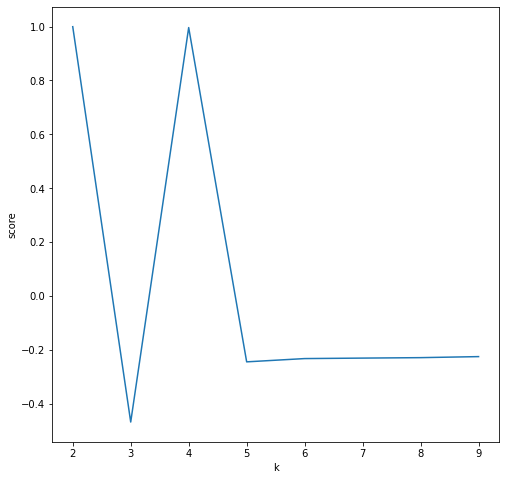

In [ ]:
# Visualize silhouette scores
fig, ax = plt.subplots(1,1, figsize =(8,8))
ax.plot(range(2,10),silhouette_scores_te)
ax.set_xlabel('k')
ax.set_ylabel('score')

In [ ]:
# Train a k-means model with k=4, which performed best locally based on our silhouette scores above
kmeans = KMeans().setK(4).setSeed(314)
km_model = kmeans.fit(train_clust)

# Make Predictions
# note the transform() method does prediction
predictions = km_model.transform(test_clust)

# Evaluate the Model:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# commenting this out because the output was huge 
#print("Cluster Centers: ")
#centers = km_model.clusterCenters()
#print(centers)

Silhouette with squared euclidean distance = 0.9961403110501416


**Model 4: Gradient-boosted tree**

In [ ]:
from pyspark.ml.regression import GBTRegressor

# Train a GBT model.
gbt = GBTRegressor(featuresCol ='standardized', labelCol='closeTime', maxIter=10)

# Train model.  This also runs the indexer.
model = gbt.fit(train_df)

# Make predictions.
predictions = model.transform(test_df)

# Select example rows to display.
predictions.select("closeTime", "standardized").show(5)

# Select (prediction, true label) and compute test error
evaluator1 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(labelCol="closeTime", predictionCol="prediction", metricName="r2")

rmse = evaluator1.evaluate(predictions)
r2 = evaluator2.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("r2:  %g" % r2)

# gbtModel = model.stages[1]
# print(gbtModel)  # summary only

+---------+--------------------+
|closeTime|        standardized|
+---------+--------------------+
|        1|(280,[0,260,279],...|
|        1|(280,[0,260,279],...|
|        1|(280,[0,260,279],...|
|        3|(280,[0,260,279],...|
|        3|(280,[0,260,279],...|
+---------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 36.0345
r2:  0.22083


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bb533ae5-e690-403a-aa33-39656e712e82' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>